"""  #    
Bloque de introducción

"""  #

# Datasets
## Preparación
### Librerías

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans

"""  #    
### Función de descarga
blablabla

"""  #

In [75]:
def load_dataset(dataset_url: str, separator: str = '\s+', class_position: int = None, remove: list = None):
    """Load a dataset from a specified url into a pandas DataFrame.

    :param str dataset_url: an url from archive.ics.uci.edu
    :param str separator: file separator.
    :param int class_position: column index where classes are defined (starts by 0)
       if left empty (None), no prediction class will be used (intrinsic case).
    :param list remove: attributes indexes to remove.
    """
    # Load dataset as a pandas DataFrame from a specified url.
    dataset = pd.read_csv(dataset_url, sep=separator, header=None)

    # Extrinsic case, dataset comes with its classes.
    if class_position is not None:
        # Extract classes.
        classes = dataset.iloc[:, class_position]
        # Add class index to the indexes to remove.
        remove = [class_position] if remove is None else remove + [class_position]

    # Intrinsic case, dataset has no classes.
    else:
        classes = None

    # Remove noise attributes.
    if remove is not None:
        dataset.drop(remove, axis=1, inplace=True)

    # Force all values to be numeric.
    for (column, values) in dataset.iteritems():
        # Coerce transforms non-numeric values into NaN.
        dataset[column] = pd.to_numeric(values, errors='coerce')

    # Remove all NaN rows.
    # TODO: this might result in different classes vs attribute sizes. To be reviewed.
    dataset.dropna(inplace=True)

    return classes, dataset


"""  #    
### Función de visualización
blablabla    
la idea es que esta función sea parametrizable y que pueda colorear los clusters

"""  #


In [97]:
def plot_dataset(dataset: pd.DataFrame, classes: np.array = None) -> None:
    if classes is not None:
        # Clone dataset to avoid modifying the original one.
        dataset = dataset.copy()
        dataset['classes'] = classes
        sns.pairplot(dataset, hue='classes')
    else:
        sns.pairplot(dataset)


## Selección

"""  #    
### Dataset extrínseca
los cilindros están en posición 1 (partiendo de 0)
no los he eliminado para que veamos el hue

"""  #

In [77]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
extrinsic_classes, extrinsic_dataset = load_dataset(dataset_url, class_position=1, remove=[7, 8])

/opt/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


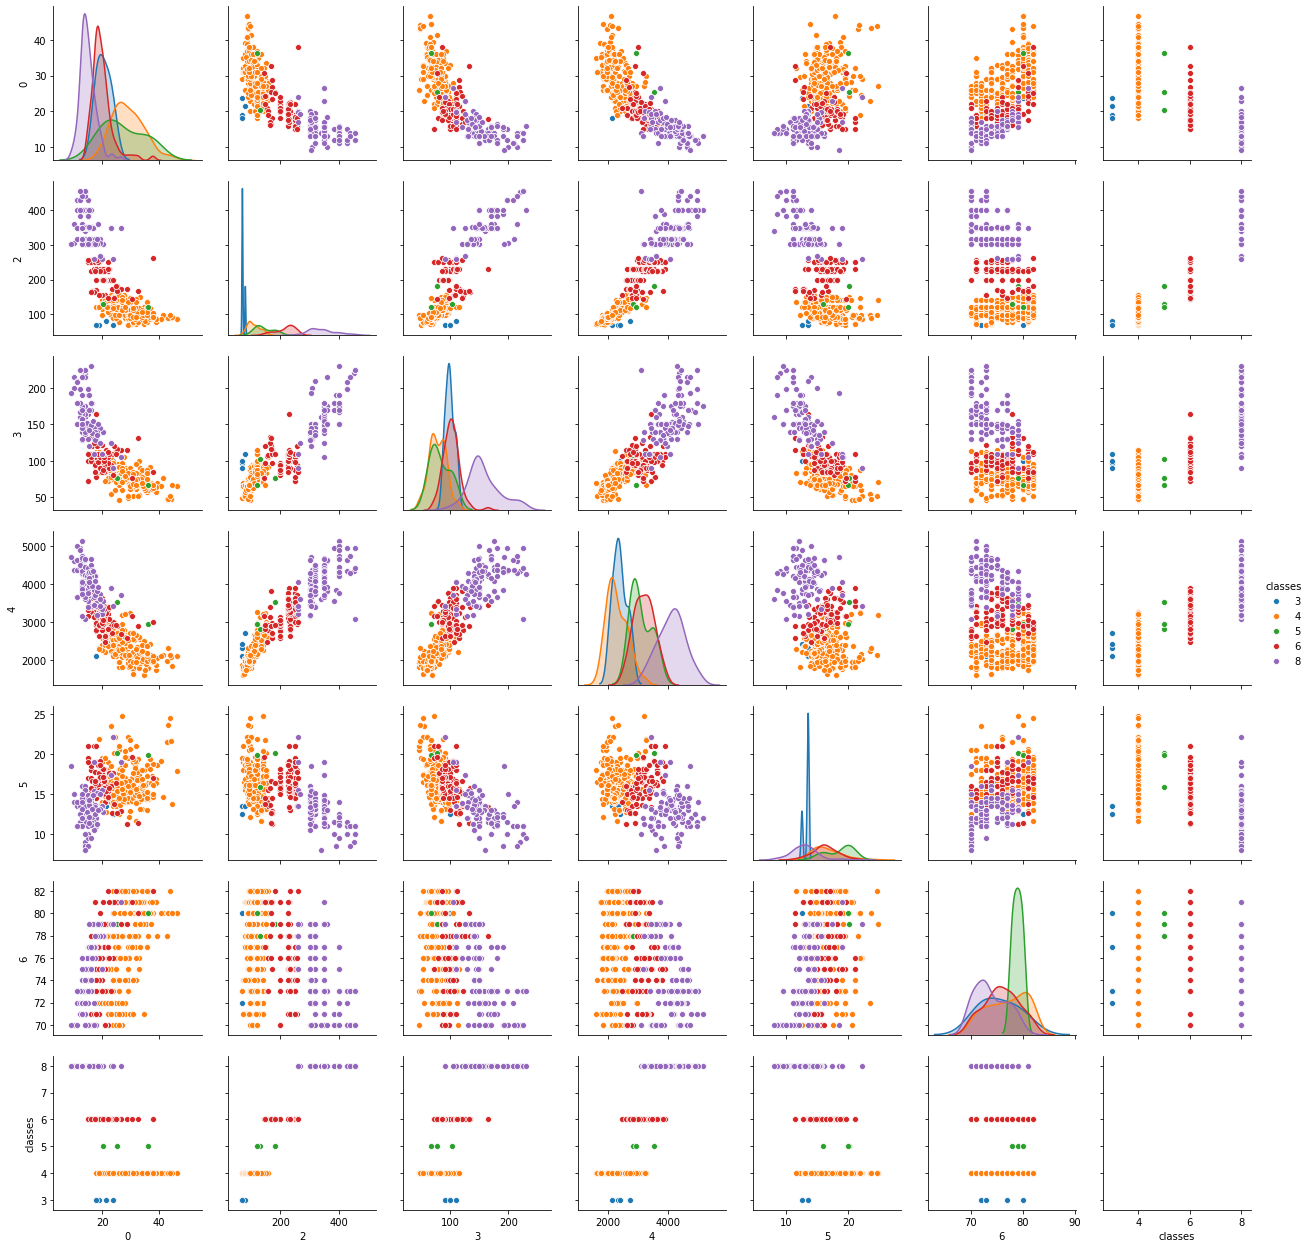

In [78]:
plot_dataset(extrinsic_dataset, extrinsic_classes)

"""  #    
blablabla

"""  #

"""  #    
## Dataset intrínseca
El dataset intrínseca **Aggregations** está generado de manera artificial por: *A. Gionis, H. Mannila, and P. Tsaparas, Clustering aggregation. ACM Transactions on Knowledge Discovery from Data (TKDD), 2007*


Este dataset está compuesto por 788 observaciones de 2 variables que abarcan un amplio rango numérico. En el conjunto de datos existen entre 5 a 7 grupos que se distribuyen en zonas particulares del rango de valores de las variables.


Cargamos nuestro dataset (*intrinsic_dataset*):

"""  #

In [98]:
dataset_url = 'http://cs.joensuu.fi/sipu/datasets/Aggregation.txt'
_, intrinsic_dataset = load_dataset(dataset_url, remove=[2])

"""  #    
Podemos ver la relación siguiente entre atríbutos:

"""  #

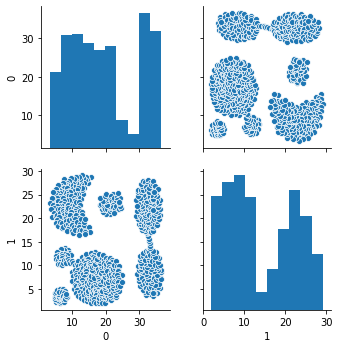

In [99]:
plot_dataset(intrinsic_dataset)

"""  #    
blablabla

"""  #

"""  #    
# Algoritmos
Preparamos funciones 'herramienta' para cada algoritmo de forma a poder analizarlos.

"""  #

## K-Means

"""  #    
Métrica R cadrado. No usamos directamente la de sklean al esta necesitar la clases reales.
Nos permite valorar el ratio de distancia intraclúster con respecto a la distancia interclúster.

"""  #


In [81]:
def r2_score(dataset, prediction, centroids):
    """
    An intrinsic R² score metric, as sklearn one is extrinsic only.
    """
    attributes_mean = np.mean(dataset, axis=0)
    labels = np.sort(np.unique(prediction))
    numerator = np.sum([
        np.sum(np.sum(dataset[prediction == label] - centroids[label], axis=1) ** 2)
        for label in labels
    ])
    denominator = np.sum(np.sum(dataset - attributes_mean, 1) ** 2)

    return 1 - numerator / denominator


"""  #    
Función para generar gráficamente la evolución de las métricas R² y Silueta según el número de cluters, de forma a escoger el número de clusters óptimo, usando la técnica del codo.

"""  #


In [82]:
def kmeans_plot_clusters_selection(dataset: pd.DataFrame, max_clusters: int = 10):
    dataset = np.array(dataset)
    silhouette_values = []
    r2_values = []
    min_clusters = 2

    for k in np.arange(min_clusters, max_clusters):
        model = KMeans(n_clusters=k).fit(dataset)
        prediction = model.predict(dataset)
        centroids = model.cluster_centers_

        silhouette_values += [metrics.silhouette_score(dataset, prediction)]
        r2_values += [r2_score(dataset, prediction, centroids)]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.arange(min_clusters, max_clusters), silhouette_values, linestyle='-', marker='o')
    ax[0].set_xlabel("Número de clústeres")
    ax[0].set_ylabel("Medida de ancho de silueta")

    ax[1].plot(np.arange(min_clusters, max_clusters), r2_values, linestyle='-', marker='o')
    ax[1].set_xlabel("Número de clústeres")
    ax[1].set_ylabel("Medida de R cuadrado")


# Análisis dataset extrínseca
## Algoritmos

"""  #    
### Algoritmo k-means
#### Selección del número de clusters

A fin de implementar el modelo de K-Medios, comencemos por determinar la cantidad óptima de centroides a utilizar a partir del Método del Codo.

"""  #

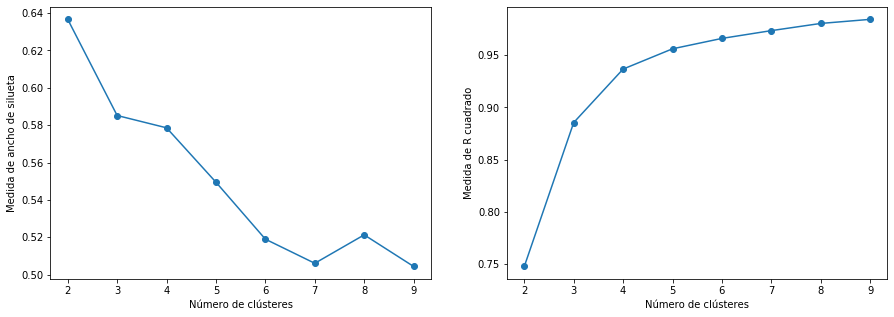

In [83]:
kmeans_plot_clusters_selection(extrinsic_dataset)

"""  #    
Según esta técnica, sería recomendable usar entre 5 y 6 clusters. Nuestro dataset viene con 6 clusters.

"""  #

#### Ejecución del algoritmo

### Algoritmo 2

### Algoritmo 3

### Algoritmo 4

### Algritmo 5

## Comparación algoritmos

# Análisis dataset intrínseca
## Algoritmos

"""  #    
### Algoritmo k-means
#### Selección del número de clusters

A fin de implementar el modelo de K-Medios, comencemos por determinar la cantidad óptima de centroides a utilizar a partir del Método del Codo.

"""  #

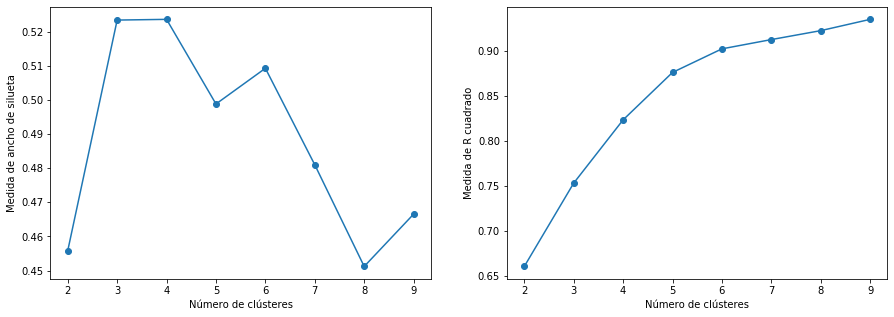

In [89]:
kmeans_plot_clusters_selection(intrinsic_dataset)

"""  #    
Según el procedimiento del codo, escogeríamos entre 5 y 7 clusters

"""  #

#### Ejecución del algoritmo

/opt/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


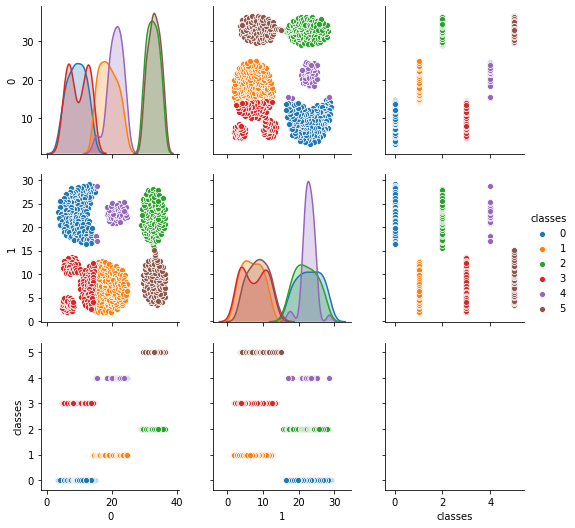

In [110]:
# Ejecutamos el algoritmo para 5 clusters y obtenemos las etiquetas y los centroids
kmeans = KMeans(n_clusters=6).fit(intrinsic_dataset)
intrinsic_prediction = kmeans.predict(intrinsic_dataset)

plot_dataset(intrinsic_dataset, intrinsic_prediction)

### Algoritmo 2

### Algoritmo 3

### Algoritmo 4

### Algoritmo 5

## Comparación algoritmos

# Conclusión